## AI Agent Bhorali

### An AI Agent that given a token address returns a full analysis report for the token with details on

Score the token from 1 to 10 for the following parameters with detailed reports
supporting each score:
    1. Very Short term investment potential (1-7 Days)
    2. Short term investment potential (1-2 months)
    3. Medium term investment potential (3-6 months)
    4. Long term investment potential (6-36 months)
    5. Value investment potential (3-10 years or maybe more)

In [2]:
from typing import Annotated, List, Optional
from typing_extensions import TypedDict
from IPython.display import Image
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt.chat_agent_executor import AgentState
import requests
from pydantic import BaseModel, Field

# web3
from web3 import Web3
from solana.rpc.async_api import AsyncClient
import asyncio
import base64

In [4]:
class AgentState(TypedDict):
    token: str # address of the token

    price_pattern_analysis: str # output of the price pattern analysis by one node
    token_distribution_analysis: str # output of the token distribution analysis by one node
    whales_analysis: str # output of the whales analysis by one node
    volume_pattern_analysis: str # output of the volume pattern analysis by one node
    token_news_analysis: str # output of the token news analysis by one node

    final_report: str # final report of the token analysis by master node

chain = "Ethereum"

prompt_end = f"""Analyze the price pattern data provided to you below
                for a token on {chain} and provide a detailed report detailing your critique of the investment 
                potential in the token. Your report will be forwarded to another investment expert node which
                will create a final report after analysing the data from you and from other similar nodes. So make
                sure to structure your report best for analysis by your successive agent. Also add any data if you 
                think it is relevant (and not redundant) for analysis by your successive agent."""


PRICE_PATTERN_ANALYSIS_PROMPT = f"""You are an expert Price Pattern Analyst. {prompt_end}"""

TOKEN_DISTRIBUTION_ANALYSIS_PROMPT = f"""You are an expert crypto Investment Analyst for token distribution data. {prompt_end}"""

WHALES_ANALYSIS_PROMPT = f"""You are an expert crypto investment analyst for whale addresses data. {prompt_end}"""

VOLUME_PATTERN_ANALYSIS_PROMPT = f"""You are an expert crypto investment Analyst for volume pattern data. {prompt_end}"""

TOKEN_NEWS_ANALYSIS_PROMPT = f"""You are an expert crypto investment analyst given the news for the token. {prompt_end}"""

FINAL_REPORT_PROMPT = """You are an expert crypto investment analyst. Analyse all the reports given to you for the token and create a final report  
                        scoring the token from 1 to 10 on the following parameters, with detailed reports supporting each score:
                        
                        1. Very Short term investment potential (1-7 Days)
                        2. Short term investment potential (1-2 months)
                        3. Medium term investment potential (3-6 months)
                        4. Long term investment potential (6-36 months)
                        5. Value investment potential (3-10 years or maybe more)"""



In [17]:
from onchain.utils import SHIB_INU, assert_token_address, get_web3
import json

ERC20_ABI = json.load(open("onchain/abis/ERC20.json"))


def get_token_name(token_address: str) -> str:
    """Returns the name of a token from its address"""
    web3 = get_web3()
    contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)
    return contract.functions.name().call()


'SHIBA INU'

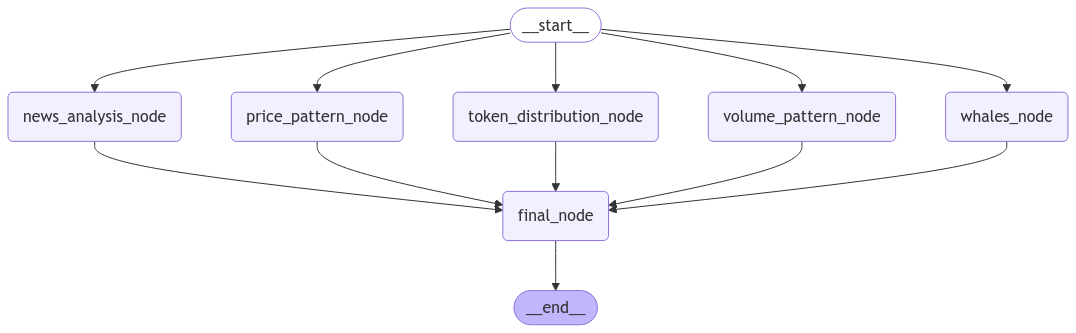

In [21]:
from onchain.price_pattern import analyze_technical_indicators, visualize_technical_analysis
from onchain.volume_pattern import analyze_token_volume_comprehensive, visualize_volume_analysis, get_ohlcv_data
from onchain.token_distribution import analyze_token_distribution
from onchain.whales import monitor_whale_wallets


search_tool = TavilySearchResults(max_results=8)

class TokenAgent:

    def __init__(self, model):
        graph_builder = StateGraph(AgentState)
        memory = MemorySaver()
        self.llm = model

        graph_builder.add_node("price_pattern_node", self.price_pattern_node)
        graph_builder.add_node("token_distribution_node", self.token_distribution_node)
        graph_builder.add_node("whales_node", self.whales_node)
        graph_builder.add_node("volume_pattern_node", self.volume_pattern_node)
        graph_builder.add_node("news_analysis_node", self.token_news_node)
        graph_builder.add_node("final_node", self.final_report_node)

        graph_builder.add_edge(START, "price_pattern_node")
        graph_builder.add_edge(START, "token_distribution_node")
        graph_builder.add_edge(START, "whales_node")
        graph_builder.add_edge(START, "volume_pattern_node")
        graph_builder.add_edge(START, "news_analysis_node")

        graph_builder.add_edge("price_pattern_node", "final_node")
        graph_builder.add_edge("token_distribution_node", "final_node")
        graph_builder.add_edge("whales_node", "final_node")
        graph_builder.add_edge("volume_pattern_node", "final_node")
        graph_builder.add_edge("news_analysis_node", "final_node")

        graph_builder.add_edge("final_node", END)

        self.graph = graph_builder.compile(checkpointer=memory)


    def price_pattern_node(self, state: AgentState):
        ohlcv_data = get_ohlcv_data(state['token'])
        raw_report = analyze_technical_indicators(ohlcv_data)

        prompt = f"""
                {PRICE_PATTERN_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"price_pattern_analysis": response}
    
    def token_distribution_node(self, state: AgentState):
        raw_report = analyze_token_distribution(state['token'])
        prompt = f"""
                {TOKEN_DISTRIBUTION_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"token_distribution_analysis": response}
    
    def whales_node(self, state: AgentState):
        raw_report = monitor_whale_wallets(state['token'])
        prompt = f"""
                {WHALES_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"whales_analysis": response}
    
    def volume_pattern_node(self, state: AgentState):
        ohlcv_data = get_ohlcv_data(state['token'])
        raw_report = analyze_token_volume_comprehensive(state['token'], ohlcv_data)
        prompt = f"""
                {VOLUME_PATTERN_ANALYSIS_PROMPT}

                Token address: {state['token']}

                Data: {raw_report}
                """

        response = self.llm.invoke(prompt)
        return {"volume_pattern_analysis": response}
    
    def token_news_node(self, state: AgentState):

        # get token name from token address
        token_name = get_token_name(state['token'])

        search_query = f"Token: {token_name}; Chain: {chain}; cryptocurrency news"
        search_results = search_tool.invoke(search_query, search_depth="advanced")

        # Extract relevant news from search results
        news_items = []
        for result in search_results:
            news_items.append(result['content'])
        
        prompt = f"""
                {TOKEN_NEWS_ANALYSIS_PROMPT}   

                Token address: {state['token']}
                Token name: {token_name}

                News: {news_items}
                """

        response = self.llm.invoke(prompt)
        return {"token_news_analysis": response}
    
    def final_report_node(self, state: AgentState):
        prompt = f"""
                {FINAL_REPORT_PROMPT}

                Token address: {state['token']}

                Price pattern analysis: {state['price_pattern_analysis']}
                Token distribution analysis: {state['token_distribution_analysis']}
                Whales analysis: {state['whales_analysis']}
                Volume pattern analysis: {state['volume_pattern_analysis']}
                Token news analysis: {state['token_news_analysis']}
                """

        response = self.llm.invoke(prompt)
        
        return {"final_report": response}
    
    def show_graph(self):
        return Image(self.graph.get_graph().draw_mermaid_png())

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
agent = TokenAgent(model)

agent.show_graph()

In [23]:
    
thread = {"configurable": {"thread_id": "1"}}
state = agent.graph.invoke({"token": SHIB_INU}, thread)

print(state['final_report'])

content="# Investment Analysis Report for Token Address: 0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE (Shiba Inu - SHIB)\n\n## Executive Summary\nThe analysis of Shiba Inu (SHIB) reveals a complex investment landscape characterized by high volatility, significant concentration among top holders, and mixed market sentiment. While there are potential short-term trading opportunities, the long-term outlook is clouded by risks associated with its meme coin status and market manipulation concerns. This report evaluates SHIB's investment potential across various time horizons, scoring each parameter from 1 to 10.\n\n## Investment Potential Scoring\n\n### 1. Very Short Term Investment Potential (1-7 Days)\n**Score: 5/10**\n- **Analysis**: The token has shown recent volatility, with whale activity indicating potential short-term price movements. However, the bearish trend indicated by technical indicators (MACD, Bollinger Bands) suggests caution. The price is currently near key Fibonacci support